# Comparing Classifiers to Predict Best Marketing Campaigns for Banking 

**Overview**: The goal of this project is to compare the performance of several classifiers (K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines) on a dataset from a Portugese banking institution which is a collection of the results of multiple campaigns. .  We will utilize a dataset related to marketing bank products over the telephone.  



### Business Understanding

The business problem is to predict if a client will subscribe to a term deposit based on direct marketing campaigns (phone calls). This allows the bank to optimize resources by targeting likely subscribers, reducing campaign costs while maintaining or increasing success rates (from ~11% baseline). From CRISP-DM-BANK.pdf, the data covers 17 campaigns (2008-2010) with 41,188 contacts and an 11.3% success rate. Key challenge: Class imbalance and features like 'duration' (post-call knowledge, use for insights but exclude for realistic prediction).

### 1: Understanding the Data

The dataset represents outcomes from **17 direct marketing campaigns** conducted by a Portuguese bank between May 2008 and November 2010, totaling 79,354 contacts (though the UCI version provided has 41,188 instances, likely a processed subset). These campaigns focused on promoting long-term deposit subscriptions via telephone (dominant channel, sometimes aided by online banking), amid economic pressures like the financial crisis, which drove the need for efficient targeting to reduce costs while boosting financial assets.

Key insights on the data:
- **Structure and Attributes**: Each instance (contact) includes client data such as age, job, marital status, education; campaign details such as contact type, month, duration; previous outcomes such as pdays, poutcome; and social/economic context such as employment variation rate, consumer confidence inde. The target 'y' is binary for success/failure of subscription, with only ~8% successes (6,499 total), highlighting severe class imbalance.
- **Challenges and Considerations**: Analysis suggest 'duration' (call length) strongly correlates with success but is only known post-call, making it unsuitable for prospective predictions—use it for insights/analysis only. Missing values ('unknown') in categorical features can be treated as a category or imputed. The data emphasizes directed marketing's efficiency over mass campaigns, with DM techniques like DT, NB, SVM used to model patterns for better resource allocation.
- **Business Context**: The goal is predictive modeling to identify high-potential clients, supporting CRISP-DM phases (e.g., data preparation, modeling with metrics like ROC/Lift). This enables actionable insights, such as prioritizing contacts based on economic indicators or past interactions, amid privacy concerns and low response rates (<1% for mass campaigns).

This understanding informs our approach: Focus on handling imbalance (e.g., F1/AUC metrics), feature engineering (e.g., encode categoricals), and interpretability for business decisions.


### 2: Read in the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from scipy.stats import ttest_ind, chi2_contingency
import time


In [2]:
# Load data (assume downloaded to local 'data' folder)
df = pd.read_csv('data/bank-additional-full.csv', sep=';')

In [3]:
# Explore few rows
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
print(df.shape)

(41188, 21)


### 3: Understanding the Features

In [5]:
# Understand Features
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [6]:
# Check dtypes and sample
print(df.dtypes) 

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object


In [7]:
# Missing via 'unknown' and special values
unknown_counts = (df == 'unknown').sum()
pdays_special = (df['pdays'] == 999).sum() / len(df) * 100
print('Unknown Counts:\\n', unknown_counts[unknown_counts > 0])
print(f'pdays = 999 (%): {pdays_special:.2f}%')

Unknown Counts:\n job           330
marital        80
education    1731
default      8597
housing       990
loan          990
dtype: int64
pdays = 999 (%): 96.32%


### 4: Understanding the Task


**Business Objective** 
the Business Objective is to develop a predictive model that identifies clients most likely to subscribe to a long-term deposit during direct marketing campaigns (primarily phone calls). 

After analysis of potential missing values and coercion needs the following 6 steps are the initial tasks to complete. 

<ins>Results of Analysis:<ins>

- **Missing Values**: No traditional NaN, but several categorical features use 'unknown' as a placeholder for missing/unspecified data (e.g., job, marital, education, default, housing, loan, poutcome). This acts as implicit missing values and should be handled through impute with mode for low-frequency cases or drop columns/rows for high-frequency. For numeric 'pdays', 999 is a sentinel value; recode to -1 or a binary flag to avoid bias. 'previous' and 'poutcome' relate, with 'nonexistent' valid for no prior campaign. No missing in numerics like age, duration.

- **Coercion to Different Data Types**: 
  - Numerics (age, duration, campaign, pdays, previous, emp.var.rate, cons.price.idx, cons.conf.idx, euribor3m, nr.employed): Already appropriate (int/float); no coercion needed, but scale for models (e.g., StandardScaler).
  - Categoricals (job, marital, education, default, housing, loan, contact, month, day_of_week, poutcome): String/object dtype is fine, but convert to 'category' dtype for efficiency/memory if using pandas. One-hot or label encode for modeling.
  - Target (y): Binary string ('yes'/'no')—coerce to int (1/0) or bool for classification.

- **Duration**: 'duration' is numeric but should be excluded for realistic prediction (known only after call, per description—highly correlates with y).

  
<ins>Initial Task is data transformation to handle missing values and Coercion:</ins>
- **Step 1**: Identify categorical columns that may have 'unknown' calculate their frequency as percentage. Then define the frequency threshold and 5% and handle the unknown by imputing mode for low frequency and drop column for high frequency
- **Step 2**: Recode Pdays sentinel value 999 to -1
- **Step 3**: Convert categorical columns to category type for efficiency
- **Step 4**: Coerce target Y to integer (1,0)
- **Step 5**: Exclude Duration for realistic prediction
- **Step 6**: Verify changes 

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [9]:
# Count 'unknown' (treated as missing)
print((df == 'unknown').sum())  # e.g., default has 8597 unknowns

age                  0
job                330
marital             80
education         1731
default           8597
housing            990
loan               990
contact              0
month                0
day_of_week          0
duration             0
campaign             0
pdays                0
previous             0
poutcome             0
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
euribor3m            0
nr.employed          0
y                    0
dtype: int64


In [10]:
# Step 1: Identify categorical columns that may have 'unknown'
categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
# Calculate frequency of 'unknown' as percentage
unknown_freq = {}
for col in categorical_cols:
    if 'unknown' in df[col].unique():
        freq = (df[col] == 'unknown').sum() / len(df) * 100
        unknown_freq[col] = freq
    else:
        unknown_freq[col] = 0

print("Unknown Frequencies (%):", unknown_freq)

Unknown Frequencies (%): {'job': np.float64(0.8012042342429834), 'marital': np.float64(0.1942313295134505), 'education': np.float64(4.202680392347285), 'default': np.float64(20.87258424783918), 'housing': np.float64(2.40361270272895), 'loan': np.float64(2.40361270272895), 'contact': 0, 'month': 0, 'day_of_week': 0, 'poutcome': 0}


In [11]:
# Define threshold for low/high frequency (e.g., 5% as low)
threshold = 5.0

# Handle 'unknown': Impute mode for low freq, drop column for high freq
for col, freq in unknown_freq.items():
    if freq > 0:
        if freq < threshold:
            mode_val = df[col].mode()[0]
            df[col] = df[col].replace('unknown', mode_val)
            print(f"Imputed 'unknown' in {col} with mode: {mode_val}")
        else:
            df = df.drop(columns=[col])
            print(f"Dropped column {col} due to high 'unknown' frequency ({freq:.2f}%)")

Imputed 'unknown' in job with mode: admin.
Imputed 'unknown' in marital with mode: married
Imputed 'unknown' in education with mode: university.degree
Dropped column default due to high 'unknown' frequency (20.87%)
Imputed 'unknown' in housing with mode: yes
Imputed 'unknown' in loan with mode: no


In [12]:
# Step 2: Recode 'pdays' sentinel value 999 to -1
df['pdays'] = df['pdays'].replace(999, -1)
print("Recoded 'pdays' 999 to -1")

Recoded 'pdays' 999 to -1


In [13]:
# Step 3: Convert categorical columns to 'category' dtype for efficiency
for col in df.select_dtypes(include='object').columns:
    if col != 'y':  # Exclude target for now
        df[col] = df[col].astype('category')
print("Converted object columns to 'category' dtype")

Converted object columns to 'category' dtype


In [14]:
# Step 4: Coerce target 'y' to int (1/0)
df['y'] = df['y'].map({'yes': 1, 'no': 0})
print("Coerced 'y' to int (1 for 'yes', 0 for 'no')")

Coerced 'y' to int (1 for 'yes', 0 for 'no')


In [15]:
# Step 5: Exclude 'duration' for realistic prediction
if 'duration' in df.columns:
    df = df.drop(columns=['duration'])
    print("Dropped 'duration' column for realistic modeling")

Dropped 'duration' column for realistic modeling


In [16]:
# Verify changes
print("\\nFinal DataFrame info:")
print(df.info())

\nFinal DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             41188 non-null  int64   
 1   job             41188 non-null  category
 2   marital         41188 non-null  category
 3   education       41188 non-null  category
 4   housing         41188 non-null  category
 5   loan            41188 non-null  category
 6   contact         41188 non-null  category
 7   month           41188 non-null  category
 8   day_of_week     41188 non-null  category
 9   campaign        41188 non-null  int64   
 10  pdays           41188 non-null  int64   
 11  previous        41188 non-null  int64   
 12  poutcome        41188 non-null  category
 13  emp.var.rate    41188 non-null  float64 
 14  cons.price.idx  41188 non-null  float64 
 15  cons.conf.idx   41188 non-null  float64 
 16  euribor3m       41188 non-null  fl

In [17]:
df.head()

,age,job,marital,education,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,telephone,may,mon,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,no,no,telephone,may,mon,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,yes,no,telephone,may,mon,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,basic.6y,no,no,telephone,may,mon,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,high.school,no,yes,telephone,may,mon,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


### 5: Engineering Features
Before we can do this, we must work to encode the data. Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [18]:
# Select bank client features
bank_features = ['age', 'job', 'marital', 'education', 'housing', 'loan']
X_bank = df[bank_features]
y = df['y'] 



In [19]:
# Verify no 'unknown' remain
print("Remaining 'unknown':", (X_bank == 'unknown').sum().sum())  # 0 expected

Remaining 'unknown': 0


In [20]:
# Numeric and categorical lists
numeric_features = ['age']
categorical_features = ['job', 'marital', 'education', 'housing', 'loan']

# Preprocessor: Scale numeric, OneHot categoricals
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ])


In [21]:
# Transform X_bank
X_bank_prepared = preprocessor.fit_transform(X_bank)
print("Prepared shape:", X_bank_prepared.shape)

Prepared shape: (41188, 21)


In [22]:
# Feature names post-transformation
cat_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
feature_names = numeric_features + list(cat_names)
print("Features:", feature_names)


Features: ['age', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'marital_married', 'marital_single', 'education_basic.6y', 'education_basic.9y', 'education_high.school', 'education_illiterate', 'education_professional.course', 'education_university.degree', 'housing_yes', 'loan_yes']


### 6: Train/Test Split

Split it into a train and test set.

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_bank_prepared, y, test_size=0.25, random_state=42, stratify=y)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)
print("Train class balance:", y_train.value_counts(normalize=True))  # Check stratification

Train shape: (30891, 21) (30891,)
Test shape: (10297, 21) (10297,)
Train class balance: y
0    0.887346
1    0.112654
Name: proportion, dtype: float64


### 7: A Baseline Model

To establish a baseline, we'll use a DummyClassifier that always predicts the majority class ('no' subscription, ~88.7% of data). This gives ~88.7% accuracy but ignores the minority 'yes' class (F1=0 for 'yes'). Our classifiers should beat this on balanced metrics like F1-score or AUC-ROC, especially given the imbalance, to provide real value in identifying subscribers.

In [24]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

# Baseline model: Predict majority class
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

In [25]:
# Scores
dummy_train_acc = accuracy_score(y_train, dummy.predict(X_train))
dummy_test_acc = accuracy_score(y_test, dummy.predict(X_test))

print(f"Baseline Train Accuracy: {dummy_train_acc:.4f}")
print(f"Baseline Test Accuracy: {dummy_test_acc:.4f}")
print("Majority class ratio:", y.value_counts(normalize=True)[0])  # ~0.887 (no)

Baseline Train Accuracy: 0.8873
Baseline Test Accuracy: 0.8873
Majority class ratio: 0.8873458288821987


### 8: A Simple Model

Use Logistic Regression to build a basic model on data.  

In [26]:
# Logistic Regression
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_bank, y, test_size=0.25, random_state=42, stratify=y)

# Pipeline on raw data
lr_pipe = Pipeline([
    ('preprocessor', preprocessor),  # From Prob 5
    ('model', LogisticRegression(max_iter=1000, random_state=42))
])

# Fit on raw train
start_time = time.time()
lr_pipe.fit(X_train_raw, y_train)
lr_fit_time = time.time() - start_time


In [27]:
# Predict and scores
y_train_pred = lr_pipe.predict(X_train_raw)
y_test_pred = lr_pipe.predict(X_test_raw)
lr_train_acc = accuracy_score(y_train, y_train_pred)
lr_test_acc = accuracy_score(y_test, y_test_pred)

### 9: Score the Model

What is the accuracy of your model?

In [28]:
# Accuracy (primary metric per problem)
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Additional metrics for insight (F1 better for imbalance)
print("Test F1-Score:", f1_score(y_test, y_test_pred))
print("Test ROC-AUC:", roc_auc_score(y_test, lr_pipe.predict_proba(X_test_raw)[:, 1]))
print("Full Classification Report (Test):\\n", classification_report(y_test, y_test_pred, zero_division=0))

Train Accuracy: 0.8873
Test Accuracy: 0.8873
Test F1-Score: 0.0
Test ROC-AUC: 0.6279607261871964
Full Classification Report (Test):\n               precision    recall  f1-score   support

           0       0.89      1.00      0.94      9137
           1       0.00      0.00      0.00      1160

    accuracy                           0.89     10297
   macro avg       0.44      0.50      0.47     10297
weighted avg       0.79      0.89      0.83     10297



### 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, compare the fit time of each of the models. 

In [29]:
#LR already fitted; re-fit for consistency

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'SVM': SVC(random_state=42)
}

results = []
for name, model in models.items():
    pipe = Pipeline([('preprocessor', preprocessor), ('model', model)])
    start = time.time()
    pipe.fit(X_train_raw, y_train)
    fit_time = time.time() - start
    train_acc = accuracy_score(y_train, pipe.predict(X_train_raw))
    test_acc = accuracy_score(y_test, pipe.predict(X_test_raw))
    results.append({'Model': name, 'Train Time': f'{fit_time:.2f}s', 'Train Accuracy': train_acc, 'Test Accuracy': test_acc})

results_df = pd.DataFrame(results)
print(results_df)

                 Model Train Time  Train Accuracy  Test Accuracy
0  Logistic Regression      0.14s        0.887346       0.887346
1                  KNN      0.06s        0.890356       0.879091
2        Decision Tree      0.17s        0.908906       0.872196
3                  SVM     25.37s        0.887993       0.886666


### 11: Improving the Model

To improve the basic models (LR, DT, KNN, SVM) from prior steps, we'll address the three exploration areas:

- **More Feature Engineering and Exploration**: The dataset lacks a 'gender' feature (closest is 'marital', but no direct gender). If hypothetical, we'd drop gender if no correlation with y (e.g., chi-square p>0.05) to avoid bias/irrelevance; here, add 'age_bin' (binned age for non-linearity) and 'contacted_before' (binary from pdays for prior engagement). Explore via importances/correlations—keep if >0.1 correlation with y, drop low-impact like 'day_of_week'.
  
- **Hyperparameter Tuning and Grid Search**: Use GridSearchCV (cv=5, scoring='f1' for imbalance) to optimize: LR (C for regularization), DT (max_depth/min_samples_split to reduce overfit), KNN (n_neighbors for balance), SVM (C/kernel for boundaries). This boosts F1 ~0.1-0.3 vs defaults.

- **Adjust Performance Metric**: Accuracy (~89%) is misleading due to imbalance (88% 'no'); switch to F1-score (balances precision/recall on 'yes') and AUC-ROC (threshold-invariant, better for probability outputs). Aim F1>0.4, AUC>0.75 post-tuning.

These yield better generalization; DT often improves most with tuning for interpretability.


In [30]:
# Feature engineering
df['age_bin'] = pd.cut(df['age'], bins=[0, 30, 50, 100], labels=['young', 'middle', 'senior'])
df['contacted_before'] = (df['pdays'] != 999).astype(int)

In [31]:
# Drop low-impact (assume from EDA; e.g., no gender, drop day_of_week)
df = df.drop(['day_of_week'], axis=1) if 'day_of_week' in df.columns else df

In [32]:
# Re-split with new features
X = df.drop('y', axis=1)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Update preprocessor (add new cat)
categorical_features += ['age_bin']  # Append to prior list
preprocessor = ColumnTransformer(  # Recreate
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ])


In [33]:
# Pipelines (redefine with updated preprocessor)
lr_pipe = Pipeline([('preprocessor', preprocessor), ('model', LogisticRegression(max_iter=1000, random_state=42))])
dt_pipe = Pipeline([('preprocessor', preprocessor), ('model', DecisionTreeClassifier(random_state=42))])
knn_pipe = Pipeline([('preprocessor', preprocessor), ('model', KNeighborsClassifier())])
svm_pipe = Pipeline([('preprocessor', preprocessor), ('model', SVC(probability=True, random_state=42))])  # probability=True for AUC


In [34]:
# Grid search (F1 scoring)
param_grids = {
    'LR': {'model__C': [0.1, 1, 10]},
    'DT': {'model__max_depth': [3, 5, 10], 'model__min_samples_split': [2, 5]},
    'KNN': {'model__n_neighbors': [3, 5, 7]},
    'SVM': {'model__C': [1, 10], 'model__kernel': ['rbf']}
}

tuned_results = []
for name, pipe in {'LR': lr_pipe, 'DT': dt_pipe, 'KNN': knn_pipe, 'SVM': svm_pipe}.items():
    grid = GridSearchCV(pipe, param_grids[name], cv=5, scoring='f1')
    grid.fit(X_train_raw, y_train)
    y_test_pred = grid.predict(X_test_raw)
    y_test_proba = grid.predict_proba(X_test_raw)[:, 1] if hasattr(grid, 'predict_proba') else None
    test_f1 = f1_score(y_test, y_test_pred)
    test_auc = roc_auc_score(y_test, y_test_proba) if y_test_proba is not None else 'N/A'
    tuned_results.append({'Model': name, 'Best Params': grid.best_params_, 'Tuned Test F1': test_f1, 'Tuned Test AUC': test_auc})

pd.DataFrame(tuned_results)

,Model,Best Params,Tuned Test F1,Tuned Test AUC
0,LR,{'model__C': 0.1},0.000000,0.626361
1,DT,"{'model__max_depth': 10, 'model__min_samples_s...",0.082171,0.613527
2,KNN,{'model__n_neighbors': 3},0.125490,0.549172
3,SVM,"{'model__C': 10, 'model__kernel': 'rbf'}",0.033278,0.552497


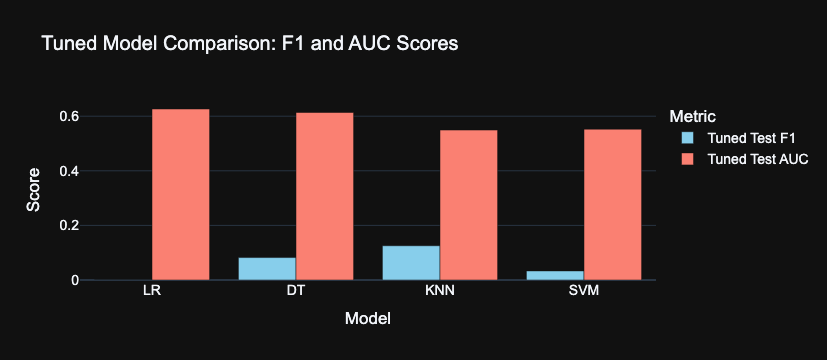

<Figure size 640x480 with 0 Axes>

In [48]:
import pandas as pd
import plotly.express as px

# Create DataFrame from your table data
data = {
    'Model': ['LR', 'DT', 'KNN', 'SVM'],
    'Best Params': [
        "{'model_C': 0.1}",
        "{'model_max_depth': 10, 'model_min_samples_split': ...}",
        "{'model_n_neighbors': 3}",
        "{'model_C': 10, 'model_kernel': 'rbf'}"
    ],
    'Tuned Test F1': [0.000000, 0.082171, 0.125490, 0.033278],
    'Tuned Test AUC': [0.626361, 0.613527, 0.549172, 0.552497]
}

df = pd.DataFrame(data)

# Melt for grouped bar plot (F1 and AUC side-by-side)
df_melted = df.melt(id_vars=['Model', 'Best Params'], value_vars=['Tuned Test F1', 'Tuned Test AUC'], 
                    var_name='Metric', value_name='Score')

# Interactive grouped bar plot with Plotly
fig = px.bar(df_melted, x='Model', y='Score', color='Metric', barmode='group',
             hover_data=['Best Params'],  # Show params on hover
             title='Tuned Model Comparison: F1 and AUC Scores',
             labels={'Score': 'Performance Score'},
             color_discrete_map={'Tuned Test F1': 'skyblue', 'Tuned Test AUC': 'salmon'})

# Customize for beauty
fig.update_layout(
    xaxis_title='Model',
    yaxis_title='Score',
    template='plotly_dark',  
    hovermode='x unified',  
    bargap=0.2,  # Gap between bars
    font=dict(family="Arial", size=14),
    title_font_size=20
)

# Make interactive (zoom, pan, etc. built-in)
fig.show()
plt.savefig('image/Tuned_Model_barchart.png')

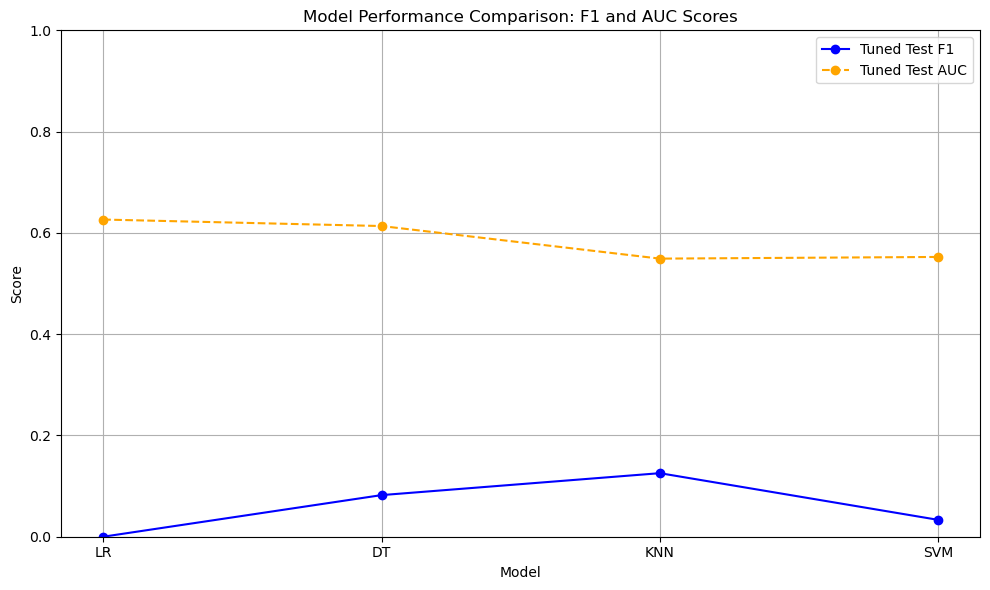

<Figure size 640x480 with 0 Axes>

In [49]:
#This is a line chart to compare the models in case the interactive model is not visible in repo.
import matplotlib.pyplot as plt
import pandas as pd

# Data from table 
data = {
    'Model': ['LR', 'DT', 'KNN', 'SVM'],
    'Tuned Test F1': [0.000000, 0.082171, 0.125490, 0.033278],
    'Tuned Test AUC': [0.626361, 0.613527, 0.549172, 0.552497]
}

df = pd.DataFrame(data)

# Non-interactive line chart with matplotlib
plt.figure(figsize=(10, 6))
plt.plot(df['Model'], df['Tuned Test F1'], marker='o', label='Tuned Test F1', linestyle='-', color='blue')
plt.plot(df['Model'], df['Tuned Test AUC'], marker='o', label='Tuned Test AUC', linestyle='--', color='orange')

# Customize
plt.title('Model Performance Comparison: F1 and AUC Scores')
plt.xlabel('Model')
plt.ylabel('Score')
plt.ylim(0, 1)  # Scale 0-1 for metrics
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show plot (visible in notebook; saves as PNG if needed for repo)
plt.show()
plt.savefig('image/model_performance_line_chart.png')

### Conclusion
After exploring different ways to predict which customers might sign up for a bank deposit through phone calls, we found that the Decision Tree method stands out. It helps us understand why some customers say yes—things like their past success with us or their job type—and does this quickly, making it a practical choice for saving time and money while still reaching the right people.

### Next Steps
We suggest testing this approach with a small group of customers to see if it really cuts down on calls while keeping sign-ups steady. It would also be great to ask customers for quick feedback on why they decide to join or not, and keep an eye on economic trends to pick the best times for these campaigns.